In [1]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 77.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 98.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 24.2 MB/s eta 0:00:00


# Basic analysis

Some analysis of the data

In [2]:
# Your code here 
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import pandas as pd
import numpy as np
import zipfile
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
tqdm.pandas()
#%matplotlib inline
from sklearn.model_selection import train_test_split

is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

df = pd.read_csv('./original_cleaned_lyrics.csv', on_bad_lines='skip')
df.columns
df = df.replace({'\n': ' '}, regex=True)
df.head()

GPU is available


,song,year,artist,genre,lyrics
0,ego-remix,2009.0,beyonce-knowles,Pop,Oh baby how you doing You know I'm gonna cut r...
1,then-tell-me,2009.0,beyonce-knowles,Pop,playin everything so easy it's like you seem s...
2,honesty,2009.0,beyonce-knowles,Pop,If you search For tenderness It isn't hard to ...
3,you-are-my-rock,2009.0,beyonce-knowles,Pop,Oh oh oh I oh oh oh I If I wrote a book about ...
4,black-culture,2009.0,beyonce-knowles,Pop,Party the people the people the party it's pop...


In [3]:
df.columns

Index(['song', 'year', 'artist', 'genre', 'lyrics'], dtype='object')

# Details

In [4]:
print("Data Shape    :", df.shape)
print("Song Count    :", len(df.song.unique()))
print("Year Count    :", len(df.year.unique()))
print("Artist Count  :", len(df.artist.unique()))
print("Genre Count   :", len(df.genre.unique()))

Data Shape    : (97622, 5)
Song Count    : 76614
Year Count    : 51
Artist Count  : 4885
Genre Count   : 12


# Word Count Analysis

In [5]:
# count words of lyrics
df["word_count"] = df.lyrics.str.split().str.len()
df.word_count.describe()

count    97620.000000
mean       231.929943
std        161.742601
min          1.000000
25%        132.000000
50%        192.000000
75%        279.000000
max       5806.000000
Name: word_count, dtype: float64

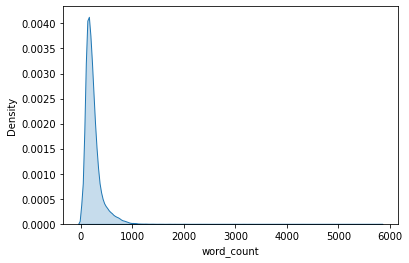

In [6]:
# density plot with shade
sns.kdeplot(df['word_count'], shade=True)
plt.show()

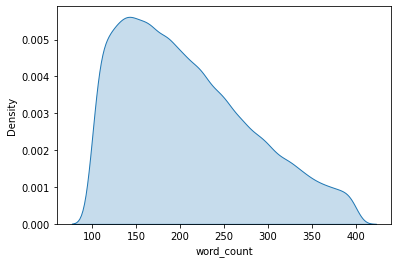

In [7]:
MAX_WORD = 400
MIN_WORD = 100
# exclude >1000
dfClean = df[df.word_count<=MAX_WORD]
# exglude also < 100
dfClean = dfClean[dfClean.word_count>=MIN_WORD]
sns.kdeplot(dfClean['word_count'], shade=True)
plt.show()

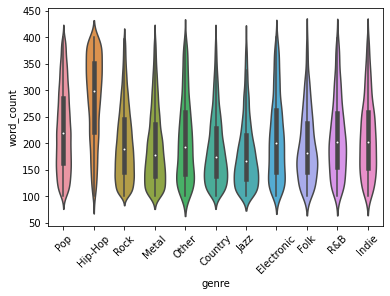

In [8]:
sns.violinplot( y=dfClean["word_count"], x=dfClean["genre"])
plt.xticks(rotation=45)
plt.show()

In [9]:
dfClean.word_count.describe()

count    74365.000000
mean       207.593088
std         73.405700
min        100.000000
25%        148.000000
50%        195.000000
75%        256.000000
max        400.000000
Name: word_count, dtype: float64

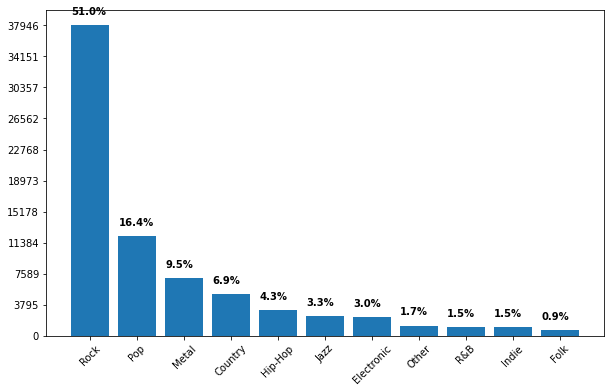

In [10]:
def plot_genres(df):
    ## Barplot for Genre count
    counts = df.genre.value_counts()
    x = counts.keys()
    max_count = df.genre.value_counts().max()
    proportions = counts/counts.sum()

    fig, ax = plt.subplots(figsize=(10,6))
    ax.bar(x, counts)
    for i, v in enumerate(x):
        ax.text(i-0.4, counts[i]+1300, "%.1f%%" % (proportions[i]*100), fontweight='bold')
    plt.xticks(rotation=45)
    plt.yticks(np.arange(0, max_count + max_count/10, max_count/10))
    plt.show()

plot_genres(dfClean)

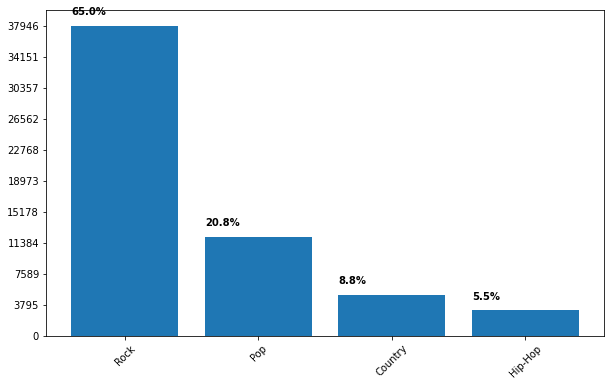

In [11]:
# We dont need Not Available and Other genres!
# We also exclude R&B, Indie and Folk, since they are very underrepresented
removeGenres = ["Not Available",
               "Other",
               "R&B",
               "Indie",
               "Folk",
                "Electronic",
                "Jazz",
                "Metal"]
dfNew = dfClean.copy()
for g in removeGenres:
    dfNew = dfNew[dfNew.genre!=g]
dfClean = dfNew
del(dfNew)
plot_genres(dfClean)

In [12]:
genre_mapping = {v:k for k, v in enumerate(set(dfClean.genre))}
genre_mapping

{'Rock': 0, 'Pop': 1, 'Hip-Hop': 2, 'Country': 3}

In [13]:
dfClean["genre_id"] = dfClean.genre.replace(genre_mapping)
dfClean.head()

,song,year,artist,genre,lyrics,word_count,genre_id
1,then-tell-me,2009.0,beyonce-knowles,Pop,playin everything so easy it's like you seem s...,258.0,1
2,honesty,2009.0,beyonce-knowles,Pop,If you search For tenderness It isn't hard to ...,170.0,1
4,black-culture,2009.0,beyonce-knowles,Pop,Party the people the people the party it's pop...,312.0,1
5,all-i-could-do-was-cry,2009.0,beyonce-knowles,Pop,I heard Church bells ringing I heard A choir s...,144.0,1
6,once-in-a-lifetime,2009.0,beyonce-knowles,Pop,This is just another day that I would spend Wa...,295.0,1


In [14]:
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(dfClean[["genre", "lyrics", "genre_id"]], test_size=0.1, random_state=12345)
df_train, df_val = train_test_split(df_train, test_size=0.11, random_state = 12345)
print("Train Data :", df_train.shape, 
      "\nVal Data   :", df_val.shape, 
      "\nTest Data  :", df_test.shape)
df_train.head()

Train Data : (46788, 3) 
Val Data   : (5783, 3) 
Test Data  : (5842, 3)


,genre,lyrics,genre_id
34613,Pop,I've felt this way for a while Like time is st...,1
70130,Hip-Hop,I just came to throw you ho's some dough pop t...,2
37029,Pop,Anthony Henry soy todo oido Henry Esa mujer s...,1
14652,Rock,I am anger Under pressure Lost it cages A pris...,0
74524,Country,Have you ever been down to a country dance And...,3


In [15]:
lyricLimit = min(df_train.groupby("genre").count().lyrics)
print("Lyric Limit per Genre:", lyricLimit)
genres = df_train.genre.unique()
balanced_df_train = pd.DataFrame()
for g in genres:
    balanced_df_train = balanced_df_train.append(df_train[df_train.genre==g].sample(lyricLimit, replace=False, random_state=12345))

Lyric Limit per Genre: 2557


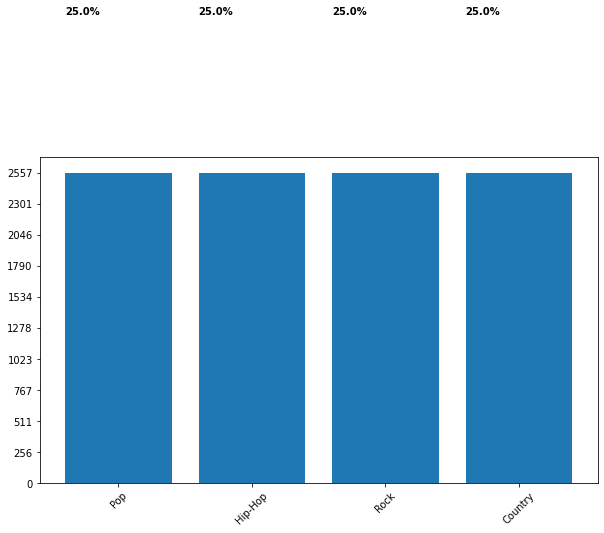

Train Data : (10228, 3)


In [16]:
df_train = balanced_df_train
del(balanced_df_train)
plot_genres(df_train)
print("Train Data :", df_train.shape)

In [17]:
df_train.to_csv("./train_unclean.csv")
df_val.to_csv("./val_unclean.csv")
df_test.to_csv("./test_unclean.csv")

In [18]:
import pandas as pd
import numpy as np
import zipfile
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
#import D.downloader as api
import sys
import spacy
import os
import torch
from datetime import datetime

from torch.utils.data import Dataset
settings = {
    "embedding_settings": {
        "embedding_type": "glove",
        "embedding_model": "glove-wiki-gigaword-300",
        "index_or_tokens": "index"
    },
    "train_data": "./data/glove_ids_train.csv.zip",
    "val_data": "./data/glove_ids_val.csv.zip",
    "test_data": "./data/glove_ids_test.csv.zip"
}


class MyDataset(Dataset):
    def __init__(self,
                 path_data,
                 max_seq_len=250):
        self.max_seq_len = max_seq_len
        self.X, self.y_id, self.y_label = self._load_data(path_data)

    def _load_data(self, data_path):
        data = pd.read_csv(data_path, index_col=[0])
        X = [[int(id) for id in row.split()] for row in data.lyrics.values]
        y_label = data.genre.values
        y_id = data.genre_id.values
        return (X, y_id, y_label)

    def __len__(self):
        return len(self.X)

    def __iter__(self):
        for i in range(len(self)):
            yield self[i]

    def __getitem__(self, index):
        _X = np.zeros(self.max_seq_len, dtype=np.int64)
        # all indexes are incremented since we have additional Padding token is added
        # to the model embeddings for index 0 in the model definitions
        item = self.X[index]
        max_i = self.max_seq_len if self.max_seq_len < len(item) else len(item)
        _X[:max_i] = np.int64(item[:max_i]) + 1
        return (index, _X, self.y_id[index], self.y_label[index])


def _batch_to_tensor(batch):
    index, _X, target_id, target_label = zip(*batch)
    return torch.LongTensor(_X), torch.LongTensor(target_id)


class MyDataset_WithPreprocess(Dataset):
    def __init__(self,
                 path_data,
                 emb_model,
                 emb_type,
                 max_seq_len=250,
                 input_type="index",
                 store_processed=False,
                 output_dir=""):
        """
        :param path_data:
            path for data location
        :param emb_model:
            a gensim.models.keyedvectors object for glove or word2vec embeddings
            or BertTokenizer for BERT embeddings
        :param emb_type:
            "gensim" or "bert"
        :param max_seq_len:
            max_seq_len that will be input of the model
            default:250
            smaller sequences will be adjusted with PADDING
        :param input_type:
            "unclean":
                It will expect the sentences as it is in the dataset and it will apply following steps:
                    - pre-processing (lowercase, rm stopwords),
                    - tokenize (split the text)
                    - converting to id
            "clean":
                It will expect the sentences already preprocessed and it will apply only following steps:
                    - tokenize,
                    - converting to id
            "index":
                It will expect the tokens in the sentence already converted to ids for the current
                embedding model and it will apply only following steps:
                    - tokenize (split text, ids are stored as text and separated with whitespace.
        :param output_dir:
            If it is sent, resulting preprocessed data will be stored at that dir as csv.
            If store_preprocessed is False, this parameter will be ignored.
        """
        # if store_preprocess = True: then it will store all indexes and training will be faster
        # else: it will preprocess it during __getitem__ function and this will make training slower...
        self.input_type = input_type
        self.emb_model = emb_model
        self.emb_type = emb_type
        self.store_preprocess = store_processed
        self.max_seq_len = max_seq_len
        self.output_dir = os.path.abspath(output_dir)

        if self.input_type == "unclean":
            self.nlp = spacy.load("en_core_web_sm", disable=["tagger", "parser", "ner"])

        if self.emb_type=="bert":
            self.func_w2i = self._bert_w2id
        elif self.emb_type=="gensim":
            self.func_w2i = self._gensim_w2id
        else:
            sys.exit("Unrecognized emb_type in MyDataset_WithPreprocess Class")



        self.X, self.y_id, self.y_label = self._load_data(path_data)

    def _load_data(self, data_path):
        data = pd.read_csv(data_path, index_col=[0])
        if self.store_preprocess and self.input_type != "index":
            print(f"Store Preprocess mode is activated. \nPreprocessing is started for {self.input_type} settings")
            if self.input_type == "unclean":
                print("Preprocess and tokenize the input...")
                X = [self.preprocess(self.nlp, lyric) for lyric in data.lyrics.values]   # clean the tokens
                print("Convert tokens to ids...")
                X = [self.func_w2i(token_list) for token_list in X]                 # convert tokens to ids
            elif self.input_type == "clean":
                X = [lyric.split() for lyric in data.lyrics.values]                 # clean tokens
                X = [self.func_w2i(token_list) for token_list in X]                 # convert tokens to ids
            else:
                sys.exit("Unrecognized input type in MyDataset_WithPreprocess Class")
            path_out = os.path.join(self.output_dir, f"{datetime.now().strftime('%y-%m-%d_%H%M%S')}_ids.csv.zip")
            print(f"Preprocessing ended! \nResults are saving to: \n\t{path_out}")
            tmp = pd.DataFrame({
                "lyrics": [" ".join([str(i) for i in id_list]) for id_list in X],
                "_lyrics": data.lyrics.values,
                "genre": data.genre.values,
                "genre_id": data.genre_id.values
            })
            tmp.to_csv(path_out, compression="zip")

        else:
            # load what we have in the lyrics directly
            if self.input_type == "index":
                X = [[int(word) for word in lyric.split()] for lyric in data.lyrics.values]
            else:
                X = [[word for word in lyric.split()] for lyric in data.lyrics.values]

        y_label = data.genre.values
        y_id = data.genre_id.values
        return (X, y_id, y_label)

    def __len__(self):
        return len(self.X)

    def __iter__(self):
        for i in range(len(self)):
            yield self[i]

    def __getitem__(self, index):
        _X = np.zeros(self.max_seq_len, dtype=np.int64)
        # all indexes are incremented since we have additional Padding token is added
        # to the model embeddings for index 0 in the model definitions
        item = self.X[index]
        if not self.store_preprocess:
            if self.input_type == "unclean":
                item = self.preprocess(self.nlp, " ".join(item))   # clean tokens
                item = self.func_w2i(item)                        # convert tokens to ids

            elif self.input_type == "clean":
                item = self.func_w2i(item)
            elif self.input_type == "index":
                pass
            else:
                sys.exit("Unrecognized input type in MyDataset_WithPreprocess Class")
        max_i = self.max_seq_len if self.max_seq_len < len(item) else len(item)
        const = 1 if self.emb_type == "gensim" else 0
        _X[:max_i] = np.int64(item[:max_i]) + const
        return index, _X, self.y_id[index], self.y_label[index]

    def _gensim_w2id(self, tokens):
        """
        :param tokens: <list> that contains tokens
        :return: <list> contains ids for the
        """
        ids = [self.emb_model.index2word.index(token)
               for token
               in tokens
               if token in self.emb_model.index2word]
        return ids

    def _bert_w2id(self, tokens):
        """
        :param tokens: <list> that contains tokens
        :return: <list> contains ids for the
        """
        ids = [self.emb_model.encode(token)[0]
               for token in tokens]
        return ids

    @staticmethod
    def preprocess(nlp, text):
        """returns a list of preprocessed tokens (tokens are strings/words)"""
        doc = nlp(text)
        out = [token.lemma_.lower() for token in doc if not token.is_stop and token.lemma_.isalpha()]
        return out

# Bert BERT Preprocessing


In [ ]:
from transformers import AutoTokenizer
#### BERT MODEL
model_name = "distilbert-base-uncased"
bertTokenizer = AutoTokenizer.from_pretrained(model_name)

In [ ]:
%%time
train_dataset = MyDataset_WithPreprocess(path_data="./train_unclean.csv",
                                         emb_model=bertTokenizer,
                                         emb_type="bert",
                                         max_seq_len=200,
                                         input_type="unclean",
                                         store_processed=True,
                                         output_dir="./data/")

Store Preprocess mode is activated. 
Preprocessing is started for unclean settings
Preprocess and tokenize the input...


/usr/local/lib/python3.8/dist-packages/spacy/pipeline/lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)


Convert tokens to ids...
Preprocessing ended! 
Results are saving to: 
	/content/data/23-03-05_224042_ids.csv.zip
CPU times: user 3min 45s, sys: 1.15 s, total: 3min 46s
Wall time: 3min 55s


In [ ]:
%%time
val_dataset = MyDataset_WithPreprocess(path_data="./val_unclean.csv",
                                       emb_model=bertTokenizer,
                                       emb_type="bert",
                                       max_seq_len=200,
                                       input_type="unclean",
                                       store_processed=True,
                                       output_dir="./data/")

Store Preprocess mode is activated. 
Preprocessing is started for unclean settings
Preprocess and tokenize the input...
Convert tokens to ids...
Preprocessing ended! 
Results are saving to: 
	/content/data/23-03-05_224243_ids.csv.zip
CPU times: user 1min 58s, sys: 443 ms, total: 1min 59s
Wall time: 2min


In [ ]:
%%time
test_dataset = MyDataset_WithPreprocess(path_data="./test_unclean.csv",
                                        emb_model=bertTokenizer,
                                        emb_type="bert",
                                        max_seq_len=200,
                                        input_type="unclean",
                                        store_processed=True,
                                        output_dir="./data/")

Store Preprocess mode is activated. 
Preprocessing is started for unclean settings
Preprocess and tokenize the input...
Convert tokens to ids...
Preprocessing ended! 
Results are saving to: 
	/content/data/23-03-05_224440_ids.csv.zip
CPU times: user 1min 57s, sys: 351 ms, total: 1min 57s
Wall time: 1min 58s


# GloVe Preprocessing

In [19]:
import gensim.downloader as api
model_name = 'glove-wiki-gigaword-300' 
glove_model = api.load(model_name)

[==================================================] 100.0% 376.1/376.1MB downloaded


In [20]:
%%time
train_dataset = MyDataset_WithPreprocess(path_data="./train_unclean.csv",
                                         emb_model=glove_model,
                                         emb_type="gensim",
                                         max_seq_len=200,
                                         input_type="unclean",
                                         store_processed=True,
                                         output_dir="./data/")

Store Preprocess mode is activated. 
Preprocessing is started for unclean settings
Preprocess and tokenize the input...


/usr/local/lib/python3.8/dist-packages/spacy/pipeline/lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)


Convert tokens to ids...
Preprocessing ended! 
Results are saving to: 
	/content/data/23-03-06_122522_ids.csv.zip
CPU times: user 15min 1s, sys: 3.89 s, total: 15min 5s
Wall time: 15min 15s


In [21]:
%%time
val_dataset = MyDataset_WithPreprocess(path_data="./val_unclean.csv",
                                       emb_model=glove_model,
                                       emb_type="gensim",
                                       max_seq_len=200,
                                       input_type="unclean",
                                       store_processed=True,
                                       output_dir="./data/")

Store Preprocess mode is activated. 
Preprocessing is started for unclean settings
Preprocess and tokenize the input...
Convert tokens to ids...
Preprocessing ended! 
Results are saving to: 
	/content/data/23-03-06_123234_ids.csv.zip
CPU times: user 7min 6s, sys: 1.78 s, total: 7min 8s
Wall time: 7min 11s


In [22]:
%%time
test_dataset = MyDataset_WithPreprocess(path_data="./test_unclean.csv",
                                        emb_model=glove_model,
                                        emb_type="gensim",
                                        max_seq_len=200,
                                        input_type="unclean",
                                        store_processed=True,
                                        output_dir="./data/")

Store Preprocess mode is activated. 
Preprocessing is started for unclean settings
Preprocess and tokenize the input...
Convert tokens to ids...
Preprocessing ended! 
Results are saving to: 
	/content/data/23-03-06_123944_ids.csv.zip
CPU times: user 7min 7s, sys: 1.95 s, total: 7min 9s
Wall time: 7min 10s


# Svm preprocess

In [38]:
# Your code here 
from nltk.stem.snowball import stopwords
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer



def clean_data(song_lyrics, stop_words):
  song_lyrics = re.sub(r'[A-Z]+', lambda b: b.group(0).lower(), song_lyrics)
  song_lyrics = re.sub(r'<[^>]+>', '', song_lyrics)
  song_lyrics = re.sub(r'https?:\/\/.*?[\s+]', '', song_lyrics) # remove url
  song_lyrics = re.sub(r'[^a-z0-9_\s]', '', song_lyrics) # alphanumeric words
  song_lyrics = re.sub(r'[^\x00-\x7f]', '', song_lyrics)
  song_lyrics = re.sub(r' +', ' ', song_lyrics)
  pattern = r'([.,!?-])'
  song_lyrics = re.sub(pattern, r' \1 ', song_lyrics)     # add whitespaces between punctuation
  song_lyrics = re.sub(r'\s{2,}', ' ', song_lyrics)   

  word_tokens = word_tokenize(song_lyrics)
  filtered = [w for w in word_tokens if not w.lower() in stop_words]
  tokenized_song_lyrics = []
  for word in filtered:
    lemmetized_word = lemmatizer.lemmatize(word)
    tokenized_song_lyrics.append(lemmetized_word)
  return tokenized_song_lyrics


nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()


print("Before: ")
df_train.head()

for index, row in df_train.iterrows():
  df_train['lyrics'][index] = clean_data(df_train['lyrics'][index], stop_words)
for index, row in df_test.iterrows():
  df_test['lyrics'][index] = clean_data(df_test['lyrics'][index], stop_words)


print("After: ")
df_train.head()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


Before: 


<ipython-input-38-31fc6d749850>:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['lyrics'][index] = clean_data(df_train['lyrics'][index], stop_words)
<ipython-input-38-31fc6d749850>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['lyrics'][index] = clean_data(df_test['lyrics'][index], stop_words)


After: 


,genre,lyrics,genre_id
62295,Pop,"[yeah, yeah, yeah, yeah, yeah, yeah, yeah, yea...",1
71663,Pop,"[look, curious, im, made, sugar, steel, kind, ...",1
57884,Pop,"[dont, apologize, cant, look, eye, kill, dont,...",1
96167,Pop,"[swimming, sweat, freshly, minted, breath, cra...",1
59122,Pop,"[thats, call, man, gon, na, warren, thats, fir...",1


In [39]:
from itertools import islice

K = 3000
most_common = dict()

for lyrics in df_train['lyrics']:
  for word in lyrics:
    if word in most_common:
      most_common[word] += 1
    else:
      most_common[word] = 1

most_common = {key: value for key, value in sorted(most_common.items(), key=lambda item: item[1], reverse = True)}
vocabulary = list(islice(most_common, K))
vocabulary.insert(0, "<unk>")
vocabulary.insert(0, "<pad>")
ix_to_word = (list(vocabulary))
# Creating a dictionary to find the index of a given word
word_to_ix = {word: ind for ind, word in enumerate(ix_to_word)}

# More compact version of the same function
def convert_token_to_indices(sentence, word_to_ix):
  return [word_to_ix.get(token, word_to_ix["<unk>"]) for token in sentence]

# Show an example

dataset = []
for lyrics in df_train['lyrics']:
  lyrics_encode = convert_token_to_indices(lyrics, word_to_ix)
  #lyrics_encode = list(filter(lambda a: a != word_to_ix["<unk>"], lyrics_encode))
  dataset.append(lyrics_encode)
dataset_test = []
for lyrics in df_test['lyrics']:
  lyrics_encode = convert_token_to_indices(lyrics, word_to_ix)
  #lyrics_encode = list(filter(lambda a: a != word_to_ix["<unk>"], lyrics_encode))
  dataset_test.append(lyrics_encode)

print(len(dataset))

10228


In [40]:
print(dataset[0])
print(len(dataset_test))
longest_list = max(len(elem) for elem in dataset_test)
print(longest_list)

[29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 3, 7, 81, 82, 141, 1, 7, 552, 2, 1115, 153, 113, 596, 219, 5, 4, 7, 57, 6, 222, 65, 5, 4, 37, 2, 1293, 7, 1115, 1057, 62, 1635, 7, 1115, 1057, 62, 1635, 63, 1635, 53, 100, 158, 7, 275, 38, 42, 28, 73, 159, 5, 4, 7, 57, 6, 222, 65, 5, 4, 37, 2, 1293, 7, 1115, 1057, 62, 1635, 7, 1115, 1057, 62, 1635, 63, 80, 1635, 2, 1115, 1057, 62, 1635, 2, 1115, 1057, 7, 1115, 7, 1115, 7, 1115, 1057, 62, 1635, 2, 1115, 1057, 62, 1635, 7, 1115, 1057, 2, 1115, 1057, 2, 1115, 1057, 2, 1115, 1057, 2, 1115, 1057, 62, 1635, 7, 1115, 1057, 7, 1115, 552, 63, 7, 1115, 1115, 1057, 7, 1115]
5842
357


In [41]:
"""
But now we got another problem. As we know, the length review sometimes is different.
So, first we need to define our maximum sequence length. Then, for each reviews that 
shorter than our predefined sequence length we will add padding token. Otherwise, 
we will trim the reviews.
"""

def pad_features(reviews, pad_id, seq_length):
    # features = np.zeros((len(reviews), seq_length), dtype=int)
    features = np.full((len(reviews), seq_length), pad_id, dtype=int)

    for i, row in enumerate(reviews):
        # if seq_length < len(row) then review will be trimmed
        features[i, :len(row)] = np.array(row)[:seq_length]

    return features

seq_length = 400
features = pad_features(dataset, pad_id=word_to_ix['<pad>'], seq_length=seq_length)
features_test = pad_features(dataset_test, pad_id=word_to_ix['<pad>'], seq_length=seq_length)
print(features[0])

[  29   29   29   29   29   29   29   29   29   29   29   29    3    7
   81   82  141    1    7  552    2 1115  153  113  596  219    5    4
    7   57    6  222   65    5    4   37    2 1293    7 1115 1057   62
 1635    7 1115 1057   62 1635   63 1635   53  100  158    7  275   38
   42   28   73  159    5    4    7   57    6  222   65    5    4   37
    2 1293    7 1115 1057   62 1635    7 1115 1057   62 1635   63   80
 1635    2 1115 1057   62 1635    2 1115 1057    7 1115    7 1115    7
 1115 1057   62 1635    2 1115 1057   62 1635    7 1115 1057    2 1115
 1057    2 1115 1057    2 1115 1057    2 1115 1057   62 1635    7 1115
 1057    7 1115  552   63    7 1115 1115 1057    7 1115    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0 

# Train SVM

In [42]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))
X,y = features,df_train['genre_id'].values
clf.fit(X, y)
Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(gamma='auto'))])


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(gamma='auto'))])

# labels

In [43]:
label_mapping = {'Rock': 0, 'Pop': 1, 'Hip-Hop': 2, 'Country': 3}
labels = [k for k,v in label_mapping.items()]
labels

['Rock', 'Pop', 'Hip-Hop', 'Country']

# Evaluation SVM

In [44]:
from sklearn import metrics
predicted = clf.predict(features_test)
y_test = df_test['genre_id'].values
print("classification:\n%s\n" % (
 metrics.classification_report(
 y_test,
 predicted, target_names=labels)))
print("Confusion matrix:\n%s" % metrics.confusion_matrix(y_test, predicted))

classification:
              precision    recall  f1-score   support

        Rock       0.70      0.24      0.36      3832
         Pop       0.27      0.25      0.26      1170
     Hip-Hop       0.19      0.59      0.29       318
     Country       0.11      0.53      0.18       522

    accuracy                           0.29      5842
   macro avg       0.32      0.40      0.27      5842
weighted avg       0.54      0.29      0.32      5842


Confusion matrix:
[[ 913  645  477 1797]
 [ 231  289  250  400]
 [  29   56  187   46]
 [ 128   65   53  276]]


# Word2Vec Preprocessing

In [ ]:
import gensim.downloader as api
model_name = 'word2vec-google-news-300' 
word2vec_model = api.load(model_name)

[=================================================-] 99.9% 1660.7/1662.8MB downloaded


In [ ]:
%%time
train_dataset = MyDataset_WithPreprocess(path_data="./train_unclean.csv",
                                         emb_model=word2vec_model,
                                         emb_type="gensim",
                                         max_seq_len=200,
                                         input_type="unclean",
                                         store_processed=True,
                                         output_dir="./data/")

Store Preprocess mode is activated. 
Preprocessing is started for unclean settings
Preprocess and tokenize the input...


/usr/local/lib/python3.8/dist-packages/spacy/pipeline/lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)


Convert tokens to ids...
Preprocessing ended! 
Results are saving to: 
	/content/data/23-03-06_095436_ids.csv.zip
CPU times: user 1h 12min 49s, sys: 12.6 s, total: 1h 13min 2s
Wall time: 1h 13min 8s


In [ ]:
%%time
val_dataset = MyDataset_WithPreprocess(path_data="./val_unclean.csv",
                                       emb_model=word2vec_model,
                                       emb_type="gensim",
                                       max_seq_len=200,
                                       input_type="unclean",
                                       store_processed=True,
                                       output_dir="./data/")

Store Preprocess mode is activated. 
Preprocessing is started for unclean settings
Preprocess and tokenize the input...
Convert tokens to ids...
Preprocessing ended! 
Results are saving to: 
	/content/data/23-03-06_102920_ids.csv.zip
CPU times: user 34min 36s, sys: 5.73 s, total: 34min 42s
Wall time: 34min 43s


In [ ]:
%%time
test_dataset = MyDataset_WithPreprocess(path_data="./test_unclean.csv",
                                        emb_model=word2vec_model,
                                        emb_type="gensim",
                                        max_seq_len=200,
                                        input_type="unclean",
                                        store_processed=True,
                                        output_dir="./data/")

Store Preprocess mode is activated. 
Preprocessing is started for unclean settings
Preprocess and tokenize the input...
Convert tokens to ids...
Preprocessing ended! 
Results are saving to: 
	/content/data/23-03-06_110350_ids.csv.zip
CPU times: user 34min 22s, sys: 5.85 s, total: 34min 28s
Wall time: 34min 30s


In [ ]:
del word2vec_model

In [ ]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import classification_report
import numpy as np

# Import Data

In [23]:
train_data= "/content/data/23-03-06_122522_ids.csv.zip"
val_data= "/content/data/23-03-06_123234_ids.csv.zip"
test_data= "/content/data/23-03-06_123944_ids.csv.zip"

In [24]:
data_train = MyDataset(path_data=train_data,
                                    max_seq_len=250)
data_val = MyDataset(path_data=val_data,
                          max_seq_len=250)
data_test = MyDataset(path_data=test_data,
                           max_seq_len=250)

# LSTM model

In [25]:
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


class MyLSTM(nn.Module):
    def __init__(self,
                 emb_vectors,
                 lstm_layers,
                 hidden_dim,
                 target_size,
                 dropout_prob,
                 device,
                 seq_len=250):
        super().__init__()
        # variable definitions
        self.hidden_dim = hidden_dim
        self.n_layers = lstm_layers
        self.device = device
        # add zero tensor at index 0 for PADDING tensor.
        # with this operation we incremented all input indexes in the dataloader.
        emb_vectors = np.insert(emb_vectors, 0, [np.zeros(300)], 0)
        self.embedding_dim = emb_vectors.shape[1]
        self.word_embeddings = nn.Embedding.from_pretrained(torch.Tensor(emb_vectors))

        self.lstm = nn.LSTM(self.embedding_dim, hidden_dim,
                            batch_first=True, num_layers=lstm_layers,
                            dropout=dropout_prob)

        self.dropout = nn.Dropout(0.1)
        self.hidden2tag = nn.Linear(hidden_dim * seq_len, target_size)
        self.sigmoid = nn.Sigmoid()
        self.log_softmax = nn.LogSoftmax(dim=1)

    def forward(self, sentence, hidden):
        embeds = self.word_embeddings(sentence)
        x, (hid, out) = self.lstm(embeds, hidden)
        x = x.contiguous().view(x.shape[0], -1)
        x = self.dropout(x)
        x = self.hidden2tag(x)
        #x = self.sigmoid(x)
        x = self.log_softmax(x)
        return x, (hid, out)

    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(self.device),
                  weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(self.device))
        return hidden

    def switch_train(self):
        self.train()

# BERT model


In [ ]:
import torch
import torch.nn as nn
import numpy as np
from transformers import AutoModel

class MyLSTM_Bert(nn.Module):
    def __init__(self,
                 lstm_layers,
                 hidden_dim,
                 target_size,
                 dropout_prob,
                 device,
                 seq_len=250,
                 bert_pretrained="distilbert-base-uncased",
                 train_bert=False):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.n_layers = lstm_layers
        self.device = device

        self.bert_pretrained = bert_pretrained
        self.train_bert = train_bert
        self.bert_model = AutoModel.from_pretrained(self.bert_pretrained)
        self.bert_emb_dim = 768

        self.lstm = nn.LSTM(self.bert_emb_dim, hidden_dim,
                            batch_first=True, num_layers=lstm_layers,
                            dropout=dropout_prob)

        self.dropout = nn.Dropout(0.1)
        self.linear1 = nn.Linear(hidden_dim*seq_len, 1024)
        self.hidden2tag = nn.Linear(hidden_dim*seq_len, target_size)
        self.sigmoid = nn.Sigmoid()
        self.log_softmax = nn.LogSoftmax(dim=1)

    def forward(self, sentence, hidden):
        with torch.no_grad():
            embeds = self.bert_model(sentence)[0]
        x, (hid, out) = self.lstm(embeds, hidden)
        x = x.contiguous().view(x.shape[0], -1)
        x = self.dropout(x)
        # x = self.linear1(x)
        x = self.hidden2tag(x)
        # x = self.sigmoid(x)
        x = self.log_softmax(x)
        return x, (hid, out)

    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(self.device),
                  weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(self.device))
        return hidden

    def switch_train(self):
        self.train()
        bert_model = next(self.children())
        bert_model.train(self.train_bert)

# CVS logger

In [26]:
import pandas as pd
import os


class CSVLogger:
    def __init__(self, metrics, output_dir="."):
        self.counter = 1
        self.output_dir = os.path.join(output_dir, "log.csv")
        self.csv_file = pd.DataFrame(columns=["epoch"].extend(metrics))

    def _append(self, row={}):
        row["epoch"] = self.counter
        if False not in [True if i in row.keys() else False for i in self.csv_file.columns]:
            self.csv_file = self.csv_file.append(row, ignore_index=True)
            self.counter += 1
        else:
            print("Row could not add!\n", row)

    def _save(self):
        self.csv_file.to_csv(self.output_dir)

    def log(self, row):
        self._append(row)
        self._save()

# Model Trainer

In [27]:
import os
import sys
import time
import json
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import DataLoader

import gensim.downloader as api
from transformers import AutoTokenizer


glove_settings = {
    "run_name": "GloveLSTM",
    "output_dir": "./output/GloveRun",
    "load_checkpoint": "",
    "mode": "train",  # train, eval

    "embedding_settings": {
        "embedding_type": "gensim",     # gensim, bert
        #"embedding_model": ["glove-wiki-gigaword-300", "word2vec-google-news-300", "distilbert-base-uncased"]
        "embedding_model": "glove-wiki-gigaword-300"
    },

    "data_settings": {
        "train_data": "/content/data/23-03-06_122522_ids.csv.zip",
        "val_data": "/content/data/23-03-06_123234_ids.csv.zip",
        "test_data": "/content/data/23-03-06_123944_ids.csv.zip",
        "max_seq_len": 200,
        "input_type": "index",    # index, clean, unclean
        "store_processed": False,
        "batch_size": 96
    },

    "model_settings": {
        "lstm_layer": 2,
        "hidden_dim": 128,
        "target_size": 4,
        "dropout_prob": 0.2
    },

    "train_settings": {
        "epochs": 25,
        "learning_rate": 0.00001,
        "grad_clip": 5
    }
}

word2vec_settings = {
    "run_name": "Word2VecLSTM",
    "output_dir": "./output/Word2VecRun",
    "load_checkpoint": "",
    "mode": "train",  # train, eval

    "embedding_settings": {
        "embedding_type": "gensim",       # gensim, bert
        ## embeding_model: ["glove-wiki-gigaword-300", "word2vec-google-news-300", "distilbert-base-uncased"]
        "embedding_model": "word2vec-google-news-300"
    },

    "data_settings": {
        "train_data": "/content/data/23-03-06_095436_ids.csv.zip",
        "val_data": "/content/data/23-03-06_102920_ids.csv.zip",
        "test_data": "/content/data/23-03-06_110350_ids.csv.zip",
        "max_seq_len": 200,
        "input_type": "index",        # index, clean, unclean 
        "store_processed": False,
        "batch_size": 96
    },

    "model_settings": {
        "lstm_layer": 2,
        "hidden_dim": 128,
        "target_size": 4,
        "dropout_prob": 0.2
    },

    "train_settings": {
        "epochs": 25,
        "learning_rate": 0.00001,
        "grad_clip": 5
    }
}


bert_settings = {
    "run_name": "BertLSTM",
    "output_dir": "./output/BertRun",
    # if load checkpoint is not empty (""), trainer will try to import checkpoint!
    "load_checkpoint": "",
    "mode": "train",  # train, eval

    "embedding_settings": {
        ## embedding_type can be: ["gensim" | "bert"]
        "embedding_type": "bert",
        ## embeding_model can be: ["glove-wiki-gigaword-300" | "word2vec-google-news-300" | "distilbert-base-uncased"]
        "embedding_model": "distilbert-base-uncased"
    },

    "data_settings": {
      "train_data": "/content/data/23-03-05_224042_ids.csv.zip",
        "val_data": "/content/data/23-03-05_224243_ids.csv.zip",
        "test_data": "/content/data/23-03-05_224440_ids.csv.zip",
        "max_seq_len": 200,
        "input_type": "index",
        "store_processed": False,
        "batch_size": 96
    },

    "model_settings": {
        "lstm_layer": 2,
        "hidden_dim": 128,
        "target_size": 4,
        "dropout_prob": 0.2,
        "train_bert": False
    },

    "train_settings": {
        "epochs": 25,
        "learning_rate": 0.00001,
        "grad_clip": 5
    }
}


class ModelTrainer:
    def __init__(self, settings, emb_model=None):
        # ################################ #
        # IDENTIFY THE DEVICE FOR TRAINING #
        # ################################ #
        self.device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

        self.load = settings["load_checkpoint"]
        self.run_mode = settings["mode"]
        if self.load != "" and self.run_mode == "train":
            checkpoint = self.get_chkp(settings["load_checkpoint"])
            self.output_dir = os.path.abspath("/".join(self.load.split("/")[:-2]))
            self.settings = checkpoint["settings"]
        else:
            self.settings = settings
            self.output_dir = settings["output_dir"]
            self.output_dir = os.path.join(self.output_dir,
                                           f"{datetime.now().strftime('%y-%m-%d_%H%M%S')}_{settings['run_name']}")
            if not os.path.exists(self.output_dir):
                os.makedirs(self.output_dir)

        self.embedding_model_name = settings["embedding_settings"]["embedding_model"]
        if isinstance(emb_model, type(None)):
            if self.embedding_model_name != "distilbert-base-uncased":
                print(f"embedding model ({self.embedding_model_name}) is loading...")
                self.emb_model = api.load(self.embedding_model_name)
            elif self.embedding_model_name == "distilbert-base-uncased":
                print(f"embedding model ({self.embedding_model_name}) is loading...")
                self.emb_model = AutoTokenizer.from_pretrained(self.embedding_model_name)
        else:
            print(f"embedding model is loaded from the argument.")
            #self.emb_model = api.load(self.embedding_model_name)
            self.emb_model = emb_model

        # ########### #
        # IMPORT DATA #
        # ########### #
        print("Importing Data...")
        self.data_train = MyDataset_WithPreprocess(path_data=settings["data_settings"]["train_data"],
                                    emb_model=self.emb_model,
                                    emb_type=settings["embedding_settings"]["embedding_type"],
                                    max_seq_len=settings["data_settings"]["max_seq_len"],
                                    input_type=settings["data_settings"]["input_type"],
                                    store_processed=settings["data_settings"]["store_processed"],
                                    output_dir=self.output_dir)
        self.data_val = MyDataset_WithPreprocess(path_data=settings["data_settings"]["val_data"],
                                  emb_model=self.emb_model,
                                  emb_type=settings["embedding_settings"]["embedding_type"],
                                  max_seq_len=settings["data_settings"]["max_seq_len"],
                                  input_type=settings["data_settings"]["input_type"],
                                  store_processed=settings["data_settings"]["store_processed"],
                                  output_dir=self.output_dir)
        self.data_test = MyDataset_WithPreprocess(path_data=settings["data_settings"]["test_data"],
                                   emb_model=self.emb_model,
                                   emb_type=settings["embedding_settings"]["embedding_type"],
                                   max_seq_len=settings["data_settings"]["max_seq_len"],
                                   input_type=settings["data_settings"]["input_type"],
                                   store_processed=settings["data_settings"]["store_processed"],
                                   output_dir=self.output_dir)

        # ############ #
        # Data Loaders #
        # ############ #
        print("Creating DataLoaders...")
        self.batch_size = settings["data_settings"]["batch_size"]
        self.dataloader_train = DataLoader(self.data_train,
                                           batch_size=self.batch_size,
                                           shuffle=True,
                                           collate_fn=_batch_to_tensor,
                                           drop_last=True)

        self.dataloader_val = DataLoader(self.data_val,
                                         batch_size=self.batch_size,
                                         shuffle=True,
                                         collate_fn=_batch_to_tensor,
                                         drop_last=True)

        self.dataloader_test = DataLoader(self.data_test,
                                          batch_size=self.batch_size,
                                          shuffle=True,
                                          collate_fn=_batch_to_tensor,
                                          drop_last=True)

        # #################### #
        # INITIALIZE THE MODEL #
        # #################### #
        print("Initializing Model...")
        if settings["embedding_settings"]["embedding_type"]=="bert":
            self.model = MyLSTM_Bert(lstm_layers=settings["model_settings"]["lstm_layer"],
                                     hidden_dim=settings["model_settings"]["hidden_dim"],
                                     target_size=settings["model_settings"]["target_size"],
                                     dropout_prob=settings["model_settings"]["dropout_prob"],
                                     device=self.device,
                                     bert_pretrained=settings["embedding_settings"]["embedding_model"],
                                     seq_len=settings["data_settings"]["max_seq_len"],
                                     train_bert=settings["model_settings"]["train_bert"])
        else:
            self.model = MyLSTM(emb_vectors=self.emb_model.vectors,
                                lstm_layers=settings["model_settings"]["lstm_layer"],
                                hidden_dim=settings["model_settings"]["hidden_dim"],
                                target_size=settings["model_settings"]["target_size"],
                                dropout_prob=settings["model_settings"]["dropout_prob"],
                                device=self.device,
                                seq_len=settings["data_settings"]["max_seq_len"])
        self.model = self.model.to(self.device)
        self.loss_function = torch.nn.NLLLoss()
        self.optimizer = torch.optim.Adam(self.model.parameters(),
                                          lr=settings["train_settings"]["learning_rate"])

        # ################# #
        # TRAINING SETTINGS #
        # ################# #
        if self.load != "" and self.run_mode == "eval":
            self.eval(data_loader=self.dataloader_test)
        elif self.load != "" and self.run_mode == "train":
            # load the last training
            print(f"The Model is loading... {self.load}")
            self.model.load_state_dict(checkpoint["state_dict"])
            self.epochs = settings["train_settings"]["epochs"]
            self.batch_counter = 0
            self.epoch_counter = checkpoint["epoch"]
            self.grad_clip = settings["train_settings"]["grad_clip"]
            self.valid_loss_min = checkpoint["valid_loss_min"]
            self.valid_acc_max = checkpoint["valid_acc_max"]
            self.metrics = checkpoint["metrics"]
            self.csv_logger = CSVLogger(self.metrics.keys())
            for i in range(len(self.metrics["train_loss"])):
                self.csv_logger.log({
                    "train_loss": self.metrics["train_loss"][i],
                    "val_loss": self.metrics["val_loss"][i],
                    "train_acc": self.metrics["train_acc"][i],
                    "val_acc": self.metrics["val_acc"][i]
                })
        elif self.load == "":
            self.epochs = settings["train_settings"]["epochs"]
            self.batch_counter = 0
            self.epoch_counter = 0
            self.grad_clip = settings["train_settings"]["grad_clip"]
            self.valid_loss_min = np.Inf
            self.valid_acc_max = np.NINF
            # Initialize metric container
            self.metrics = {
                "train_loss": [],
                "val_loss": [],
                "train_acc": [],
                "val_acc": []
            }
            self.csv_logger = CSVLogger(self.metrics.keys())
            with open(os.path.join(self.output_dir, "settings.json"), "w") as f:
                json.dump(settings, f)
        else:
            sys.exit("load and mode Settings are not identified!")

    def train(self):
        print_step_every = 100
        self.model.switch_train()
        while self.epoch_counter < self.epochs:
            self.epoch_counter += 1
            epoch = self.epoch_counter
            # initialize intermediate metrics
            self.batch_counter = 0
            training_loss = 0
            training_acc = 0
            # time vars
            ep_start_time = time.time()
            temp_time = time.time()
            # initialize hiddens
            h = self.model.init_hidden(self.batch_size)
            for inputs, labels in self.dataloader_train:
                self.batch_counter += 1

                h = tuple([e.data for e in h])
                inputs, labels = inputs.to(self.device), labels.to(self.device)

                self.optimizer.zero_grad()
                output, h = self.model.forward(inputs, h)

                preds = torch.max(output, dim=1)[1]
                loss = self.loss_function(output, labels)

                training_loss += loss.item()
                training_acc += torch.sum(preds == labels).item() / labels.shape[0]

                loss.backward()
                nn.utils.clip_grad_norm_(self.model.parameters(), self.grad_clip)
                self.optimizer.step()

                if self.batch_counter % print_step_every == 0 or self.batch_counter == 1:
                    print("Epoch: {}/{}...".format(epoch + 1, self.epochs),
                          "Step: {}...".format(self.batch_counter),
                          "Loss: {:.6f}...".format(training_loss / self.batch_counter),
                          "Acc: {:.2f}".format(training_acc / self.batch_counter),
                          "Time: {}... secs".format(time.time() - temp_time))
                    temp_time = time.time()

                # ##### END OF EPOCH ##### #
                if self.batch_counter == len(self.dataloader_train) - 1:
                    val_loss, val_acc = self.eval(self.dataloader_val)

                    row = {
                        "train_loss": training_loss / len(self.dataloader_train),
                        "train_acc": training_acc / len(self.dataloader_train),
                        "val_loss": val_loss,
                        "val_acc": val_acc
                    }
                    self._log_metrics(row)

                    print("Epoch: {}/{}...".format(epoch + 1, self.epochs),
                          "Step: {}...".format(self.batch_counter),
                          "Loss: {:.6f}...".format(row["train_loss"]),
                          "Acc: {:.2f}".format(row["train_acc"]),
                          "Val Loss: {:.6f}".format(row["val_loss"]),
                          "Val Acc: {:.2f}".format(row["val_acc"]))
                    # ## SAVE MODEL ## #
                    # save best validation accuracy
                    if self.valid_acc_max < row["val_acc"]:
                        self.valid_acc_max = row["val_acc"]
                        # self.save_model(fname=f"minAcc_epoch")
                    # save best validation loss
                    if self.valid_loss_min > row["val_loss"]:
                        self.valid_loss_min = row["val_loss"]
                        self.save_model(fname=f"minLoss_epoch")
                    # save last epoch
                    self.save_model(fname="last_epoch")

                    ep_end_time = time.time()
                    print("Epoch: {} Ended in {} secs...".format(epoch, ep_end_time - ep_start_time))


    def _log_metrics(self, row):
        self.metrics["train_loss"].append(row["train_loss"])
        self.metrics["train_acc"].append(row["train_acc"])
        self.metrics["val_loss"].append(row["val_loss"])
        self.metrics["val_acc"].append(row["val_acc"])
        self.csv_logger.log(row)

    def eval(self, data_loader=None):
        test_loss = 0
        test_acc = 0
        test_h = self.model.init_hidden(self.batch_size)

        self.model.eval()
        data_loader = self.dataloader_test if isinstance(data_loader, type(None)) else data_loader
        for inp, lab in data_loader:
            test_h = tuple([each.data for each in test_h])

            inp, lab = inp.to(self.device), lab.to(self.device)
            out, test_h = self.model(inp, test_h)

            preds = torch.max(out, dim=1)[1]
            loss = self.loss_function(out, lab)

            test_loss += loss.item()
            test_acc += torch.sum(preds == lab).item() / lab.shape[0]
        self.model.switch_train()

        loss = test_loss / len(data_loader)
        acc = test_acc / len(data_loader)
        return loss, acc

    def predict(self, data_loader=None):
        all_preds = []
        all_y = []
        test_h = self.model.init_hidden(self.batch_size)

        self.model.eval()
        data_loader = self.dataloader_test if isinstance(data_loader, type(None)) else data_loader
        for inp, lab in data_loader:
            test_h = tuple([each.data for each in test_h])

            inp, lab = inp.to(self.device), lab.to(self.device)
            out, test_h = self.model(inp, test_h)
            preds = torch.max(out, dim=1)[1]
            preds = preds.cpu()
            lab = lab.cpu()
            all_preds.extend(preds.detach().numpy())
            all_y.extend(lab.detach().numpy())
        self.model.switch_train()

        return np.array(all_preds), np.array(all_y)

    def save_model(self, fname="last_epoch"):
        state = {
            "settings": self.settings,
            "epoch": self.epoch_counter,
            "metrics": self.metrics,
            "valid_acc_max": self.valid_acc_max,
            "valid_loss_min": self.valid_loss_min,
            "optimizer": self.optimizer.state_dict(),
            "state_dict": self.model.state_dict()
        }
        o_dir = os.path.join(self.output_dir, "checkpoints")
        if not os.path.exists(o_dir):
            os.makedirs(o_dir)
        path_out = os.path.join(o_dir, f"{fname}.chkp")
        torch.save(state, path_out)

    def load_model(self, chkp_path):
        checkpoint = self.get_chkp(chkp_path)
        print(f"The Model is loading... {self.load}")
        self.output_dir = os.path.abspath("/".join(chkp_path.split("/")[:-2]))
        self.settings = checkpoint["settings"]
        self.model.load_state_dict(checkpoint["state_dict"])
        self.epoch_counter = checkpoint["epoch"]
        self.valid_loss_min = checkpoint["valid_loss_min"]
        self.valid_acc_max = checkpoint["valid_acc_max"]
        self.metrics = checkpoint["metrics"]

    def get_chkp(self, chkp_path):
        return torch.load(chkp_path, map_location=self.device)

    def save_plots(self, fname="learningCurve"):
        x = np.arange(len(self.metrics["train_loss"])) + 1
        fig, ax = plt.subplots()
        ax.plot(x, self.metrics["train_loss"], label="train")
        ax.plot(x, self.metrics["val_loss"], label="val")
        ax.set_title('Learning Curve - Loss')
        plt.legend(loc='lower right')
        plt.savefig(os.path.join(self.output_dir, f"{fname}_Loss.png"))

        fig, ax = plt.subplots()
        ax.plot(x, self.metrics["train_acc"], label="train")
        ax.plot(x, self.metrics["val_acc"], label="val")
        ax.set_title('Learning Curve - Accuracy')
        plt.legend(loc='lower right')
        plt.savefig(os.path.join(self.output_dir, f"{fname}_Acc.png"))

# labeling

In [28]:
from sklearn.metrics import classification_report
import os
label_mapping = {'Rock': 0, 'Pop': 1, 'Hip-Hop': 2, 'Country': 3}
labels = [k for k,v in label_mapping.items()]
labels

['Rock', 'Pop', 'Hip-Hop', 'Country']

# Train Word2Vec

In [ ]:
word2vec_settings

{'run_name': 'Word2VecLSTM',
 'output_dir': './output/Word2VecRun',
 'load_checkpoint': '',
 'mode': 'train',
 'embedding_settings': {'embedding_type': 'gensim',
  'embedding_model': 'word2vec-google-news-300'},
 'data_settings': {'train_data': '/content/data/23-03-06_095436_ids.csv.zip',
  'val_data': '/content/data/23-03-06_102920_ids.csv.zip',
  'test_data': '/content/data/23-03-06_110350_ids.csv.zip',
  'max_seq_len': 200,
  'input_type': 'index',
  'store_processed': False,
  'batch_size': 96},
 'model_settings': {'lstm_layer': 2,
  'hidden_dim': 128,
  'target_size': 4,
  'dropout_prob': 0.2},
 'train_settings': {'epochs': 25, 'learning_rate': 1e-05, 'grad_clip': 5}}

In [ ]:
model_trainer = ModelTrainer(word2vec_settings)

embedding model (word2vec-google-news-300) is loading...
Importing Data...
Creating DataLoaders...
Initializing Model...


In [ ]:
model_trainer.train()

<ipython-input-1-a297331d7a33>:60: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  return torch.LongTensor(_X), torch.LongTensor(target_id)


Epoch: 2/25... Step: 1... Loss: 1.385327... Acc: 0.28 Time: 1.043644905090332... secs
Epoch: 2/25... Step: 100... Loss: 1.384053... Acc: 0.31 Time: 2.3303868770599365... secs
Epoch: 2/25... Step: 105... Loss: 1.370799... Acc: 0.31 Val Loss: 1.398343 Val Acc: 0.18
Epoch: 1 Ended in 68.32851314544678 secs...
Epoch: 3/25... Step: 1... Loss: 1.384073... Acc: 0.27 Time: 0.031096220016479492... secs
Epoch: 3/25... Step: 100... Loss: 1.372051... Acc: 0.35 Time: 2.287775993347168... secs
Epoch: 3/25... Step: 105... Loss: 1.358374... Acc: 0.35 Val Loss: 1.370836 Val Acc: 0.13
Epoch: 2 Ended in 39.309539556503296 secs...
Epoch: 4/25... Step: 1... Loss: 1.354991... Acc: 0.42 Time: 0.024985074996948242... secs
Epoch: 4/25... Step: 100... Loss: 1.335540... Acc: 0.40 Time: 2.2793776988983154... secs
Epoch: 4/25... Step: 105... Loss: 1.322639... Acc: 0.39 Val Loss: 1.359103 Val Acc: 0.16
Epoch: 3 Ended in 39.23773956298828 secs...
Epoch: 5/25... Step: 1... Loss: 1.301543... Acc: 0.38 Time: 0.02348637

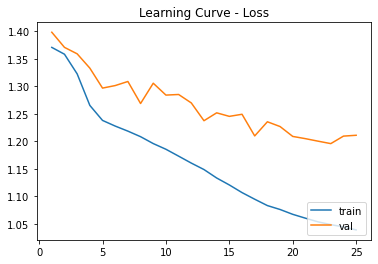

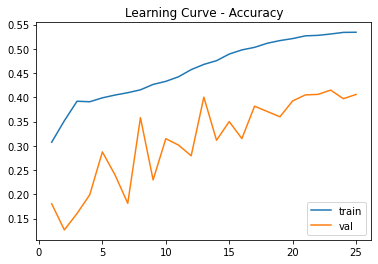

In [ ]:
model_trainer.save_plots()

# Word2Vec Evaluation

In [ ]:
path_chkp = "/content/output/Word2VecRun/23-03-06_112514_Word2VecLSTM/checkpoints/minLoss_epoch.chkp"
word2vec_settings["load_checkpoint"] = path_chkp

In [ ]:
model_trainer = ModelTrainer(word2vec_settings)

embedding model (word2vec-google-news-300) is loading...


In [ ]:
model_trainer.epoch_counter

25

In [ ]:
%%time
y_pred, y_true = model_trainer.predict()

CPU times: user 677 ms, sys: 0 ns, total: 677 ms
Wall time: 676 ms


In [ ]:
from sklearn import metrics
print(classification_report(y_true, y_pred, target_names=labels))
print("Confusion matrix:\n%s" % metrics.confusion_matrix(y_true, y_pred))

              precision    recall  f1-score   support

     Country       0.21      0.69      0.32       518
     Hip-Hop       0.27      0.72      0.39       314
        Rock       0.79      0.36      0.50      3777
         Pop       0.32      0.42      0.36      1151

    accuracy                           0.42      5760
   macro avg       0.40      0.55      0.39      5760
weighted avg       0.62      0.42      0.45      5760

Confusion matrix:
[[ 356   23   67   72]
 [  17  225   30   42]
 [1053  446 1366  912]
 [ 250  149  267  485]]


# Train Glove

In [29]:
glove_settings

{'run_name': 'GloveLSTM',
 'output_dir': './output/GloveRun',
 'load_checkpoint': '',
 'mode': 'train',
 'embedding_settings': {'embedding_type': 'gensim',
  'embedding_model': 'glove-wiki-gigaword-300'},
 'data_settings': {'train_data': '/content/data/23-03-06_122522_ids.csv.zip',
  'val_data': '/content/data/23-03-06_123234_ids.csv.zip',
  'test_data': '/content/data/23-03-06_123944_ids.csv.zip',
  'max_seq_len': 200,
  'input_type': 'index',
  'store_processed': False,
  'batch_size': 96},
 'model_settings': {'lstm_layer': 2,
  'hidden_dim': 128,
  'target_size': 4,
  'dropout_prob': 0.2},
 'train_settings': {'epochs': 25, 'learning_rate': 1e-05, 'grad_clip': 5}}

In [30]:
model_trainer = ModelTrainer(glove_settings)

embedding model (glove-wiki-gigaword-300) is loading...
Importing Data...
Creating DataLoaders...
Initializing Model...


In [31]:
model_trainer.train()

<ipython-input-18-a297331d7a33>:60: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  return torch.LongTensor(_X), torch.LongTensor(target_id)


Epoch: 2/25... Step: 1... Loss: 1.387145... Acc: 0.29 Time: 1.2017080783843994... secs
Epoch: 2/25... Step: 100... Loss: 1.378753... Acc: 0.32 Time: 2.150207042694092... secs
Epoch: 2/25... Step: 105... Loss: 1.365274... Acc: 0.32 Val Loss: 1.378522 Val Acc: 0.16
Epoch: 1 Ended in 8.594897270202637 secs...
Epoch: 3/25... Step: 1... Loss: 1.367590... Acc: 0.43 Time: 0.032494306564331055... secs
Epoch: 3/25... Step: 100... Loss: 1.352035... Acc: 0.40 Time: 2.08144211769104... secs
Epoch: 3/25... Step: 105... Loss: 1.338059... Acc: 0.39 Val Loss: 1.343248 Val Acc: 0.41
Epoch: 2 Ended in 7.617329359054565 secs...
Epoch: 4/25... Step: 1... Loss: 1.314349... Acc: 0.48 Time: 0.03484535217285156... secs
Epoch: 4/25... Step: 100... Loss: 1.302463... Acc: 0.40 Time: 2.1010472774505615... secs
Epoch: 4/25... Step: 105... Loss: 1.289249... Acc: 0.40 Val Loss: 1.314423 Val Acc: 0.31
Epoch: 3 Ended in 7.374791622161865 secs...
Epoch: 5/25... Step: 1... Loss: 1.304966... Acc: 0.36 Time: 0.03286743164

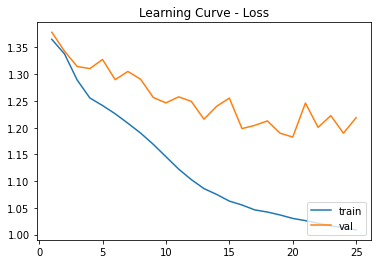

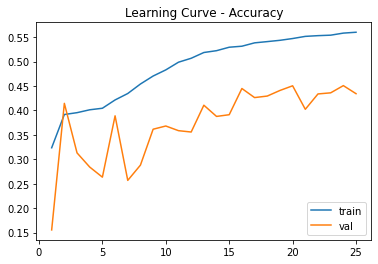

In [32]:
model_trainer.save_plots()

# Glove Evaluation

In [33]:
path_chkp = "/content/output/GloveRun/23-03-06_125623_GloveLSTM/checkpoints/minLoss_epoch.chkp"
glove_settings["load_checkpoint"] = path_chkp

In [ ]:
model_trainer = ModelTrainer(glove_settings)

embedding model (glove-wiki-gigaword-300) is loading...
Importing Data...
Creating DataLoaders...
Initializing Model...
The Model is loading... ./output/GloveRun/23-03-01_200106_GloveLSTM/checkpoints/minLoss_epoch.chkp


In [34]:
model_trainer.epoch_counter

25

In [35]:
%%time
y_pred, y_true = model_trainer.predict()

CPU times: user 803 ms, sys: 2.95 ms, total: 806 ms
Wall time: 854 ms


In [37]:
from sklearn import metrics
print(classification_report(y_true, y_pred, target_names=labels))
print("Confusion matrix:\n%s" % metrics.confusion_matrix(y_true, y_pred))

              precision    recall  f1-score   support

        Rock       0.80      0.37      0.51      3778
         Pop       0.33      0.43      0.37      1154
     Hip-Hop       0.26      0.72      0.38       314
     Country       0.23      0.73      0.35       514

    accuracy                           0.43      5760
   macro avg       0.41      0.56      0.40      5760
weighted avg       0.63      0.43      0.46      5760

Confusion matrix:
[[1400  895  459 1024]
 [ 269  492  158  235]
 [  27   46  226   15]
 [  48   69   20  377]]


# Train BERT

In [ ]:
bert_settings

{'run_name': 'BertLSTM',
 'output_dir': './output/BertRun',
 'load_checkpoint': '',
 'mode': 'train',
 'embedding_settings': {'embedding_type': 'bert',
  'embedding_model': 'distilbert-base-uncased'},
 'data_settings': {'train_data': '/content/data/23-03-05_224042_ids.csv.zip',
  'val_data': '/content/data/23-03-05_224243_ids.csv.zip',
  'test_data': '/content/data/23-03-05_224440_ids.csv.zip',
  'max_seq_len': 200,
  'input_type': 'index',
  'store_processed': False,
  'batch_size': 96},
 'model_settings': {'lstm_layer': 2,
  'hidden_dim': 128,
  'target_size': 4,
  'dropout_prob': 0.2,
  'train_bert': False},
 'train_settings': {'epochs': 25, 'learning_rate': 1e-05, 'grad_clip': 5}}

In [ ]:
model_trainer = ModelTrainer(bert_settings)

embedding model (distilbert-base-uncased) is loading...
Importing Data...
Creating DataLoaders...
Initializing Model...


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
model_trainer.train()

Epoch: 2/25... Step: 1... Loss: 1.388597... Acc: 0.26 Time: 0.5655488967895508... secs
Epoch: 2/25... Step: 100... Loss: 1.308118... Acc: 0.37 Time: 51.89508605003357... secs
Epoch: 2/25... Step: 105... Loss: 1.294575... Acc: 0.37 Val Loss: 1.324129 Val Acc: 0.15
Epoch: 1 Ended in 89.26571726799011 secs...
Epoch: 3/25... Step: 1... Loss: 1.294038... Acc: 0.36 Time: 0.5387754440307617... secs
Epoch: 3/25... Step: 100... Loss: 1.270537... Acc: 0.39 Time: 54.01444911956787... secs
Epoch: 3/25... Step: 105... Loss: 1.257516... Acc: 0.38 Val Loss: 1.306864 Val Acc: 0.29
Epoch: 2 Ended in 92.12868356704712 secs...
Epoch: 4/25... Step: 1... Loss: 1.252293... Acc: 0.36 Time: 0.5536525249481201... secs
Epoch: 4/25... Step: 100... Loss: 1.269425... Acc: 0.39 Time: 55.2448890209198... secs
Epoch: 4/25... Step: 105... Loss: 1.257031... Acc: 0.39 Val Loss: 1.336359 Val Acc: 0.22
Epoch: 3 Ended in 92.79113006591797 secs...
Epoch: 5/25... Step: 1... Loss: 1.239241... Acc: 0.36 Time: 0.589339733123779

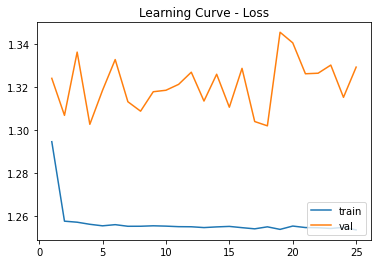

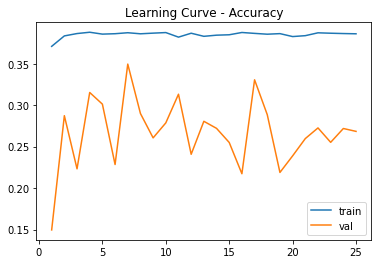

In [ ]:
model_trainer.save_plots()

# Bert evaluation

In [ ]:
path_chkp = "/content/output/BertRun/23-03-05_214307_BertLSTM/checkpoints/minLoss_epoch.chkp"
bert_settings["load_checkpoint"] = path_chkp

In [ ]:
model_trainer.epoch_counter

25

In [ ]:
%%time
y_pred, y_true = model_trainer.predict()

CPU times: user 33.1 s, sys: 49.8 ms, total: 33.1 s
Wall time: 33.1 s


In [ ]:
from sklearn import metrics
print(classification_report(y_true, y_pred, target_names=labels))

print("Confusion matrix:\n%s" % metrics.confusion_matrix(y_true, y_pred))

              precision    recall  f1-score   support

     Country       0.12      0.48      0.19       514
         Pop       0.22      0.19      0.20      1160
        Rock       0.71      0.24      0.36      3775
     Hip-Hop       0.14      0.64      0.24       311

    accuracy                           0.27      5760
   macro avg       0.30      0.39      0.25      5760
weighted avg       0.52      0.27      0.30      5760

Confusion matrix:
[[ 247   73  111   83]
 [ 341  219  234  366]
 [1487  664  898  726]
 [  30   54   29  198]]
